In [93]:
import tensorflow as tf
# TensorFlow GPU 메모리 할당 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 첫 번째 GPU에 대해 메모리 1GB만 할당
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # GPU 초기화 전에 가상 장치를 설정해야 함
    print(e)

Virtual devices cannot be modified after being initialized


In [84]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import sys
import gc
import time
import cv2
import seaborn as sns
sns.set()
import plotly
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, Input, models
import time

from IPython import display

In [1]:
import seaborn as sns

In [52]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
import cv2


from sklearn.model_selection import KFold



%matplotlib inline

from PIL import Image

In [106]:
df = pd.read_pickle("df_train.pkl")



In [107]:
df.shape

(649165, 6)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 649165 entries, 711962 to 328645
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        649165 non-null  object 
 1   dieSize         649165 non-null  float64
 2   lotName         649165 non-null  object 
 3   waferIndex      649165 non-null  float64
 4   trianTestLabel  649165 non-null  object 
 5   failureType     649165 non-null  object 
dtypes: float64(2), object(4)
memory usage: 34.7+ MB


In [109]:
df = df.drop(['waferIndex'], axis = 1)


In [110]:
#add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
381991,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22828,[],[],"(52, 59)"
323867,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4423.0,lot19600,[],[],"(74, 76)"
141230,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3927.0,lot9148,Training,Edge-Ring,"(69, 73)"
740888,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",939.0,lot44678,[],[],"(39, 31)"
464053,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",712.0,lot28547,[],[],"(32, 29)"


In [111]:
dim=df['waferMapDim'].values

### 밀집된 분포 탐지


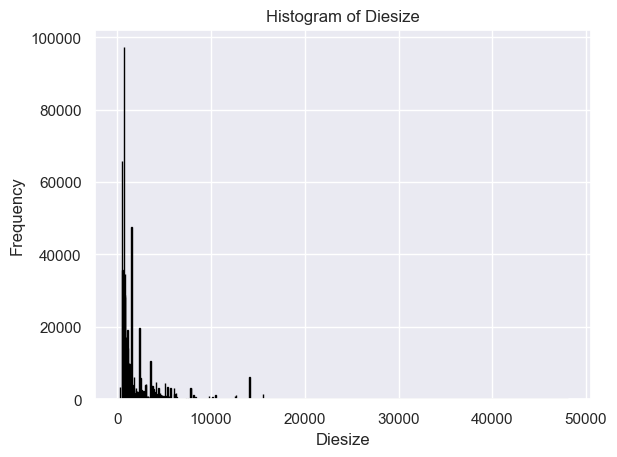

In [112]:
diesize=df['dieSize']

plt.hist(diesize, edgecolor='black', bins=1000)
plt.xlabel('Diesize')
plt.ylabel('Frequency')
plt.title('Histogram of Diesize')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_2420\243039445.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diesize, shade=True)


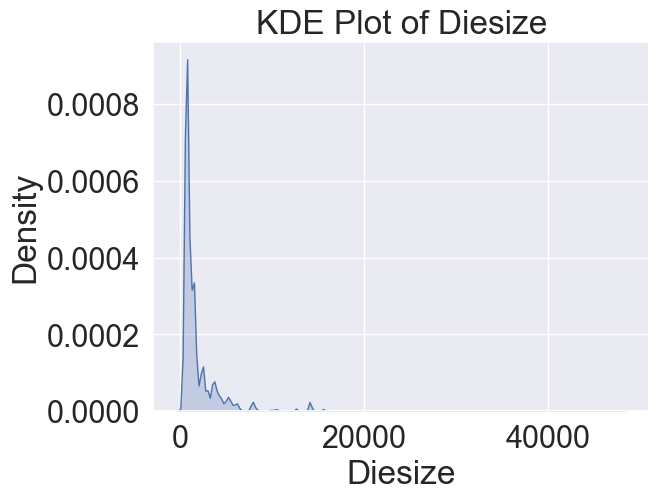

In [27]:
sns.kdeplot(diesize, shade=True)
plt.xlabel('Diesize')
plt.ylabel('Density')
plt.title('KDE Plot of Diesize')
plt.show()

In [113]:

# 1. 레이블링된 데이터 추출
labeled_data = df[df['failureType'].astype(str) != '[]'].copy()

# 2. dieSize 분포 계산
dieSize_distribution, bins = np.histogram(labeled_data['dieSize'], bins='auto')

# 3. 각 구간별 비율 계산
proportion = dieSize_distribution / dieSize_distribution.sum()

# 4. 누적 비율 계산
cumulative_proportion = np.cumsum(proportion)

# 5. 누적 비율이 0.1을 초과하는 첫 번째 구간 찾기
target_bin_index = np.argmax(cumulative_proportion > 0.1)

# 6. 해당 구간의 범위 추출
lower_bound = bins[target_bin_index]
upper_bound = bins[target_bin_index + 1]

# 7. 결과 출력
print(f"dieSize 범위: [{lower_bound}, {upper_bound})")
print(f"해당 범위 데이터 비율: {cumulative_proportion[target_bin_index]:.2%}")


dieSize 범위: [501.9368029739777, 529.6555142503098)
해당 범위 데이터 비율: 19.49%


In [114]:
# 5. 누적 비율이 0.9을 초과하는 첫 번째 구간 찾기
target_bin_index = np.argmax(cumulative_proportion > 0.9)

# 6. 해당 구간의 범위 추출
lower_bound1 = bins[target_bin_index]
upper_bound1 = bins[target_bin_index + 1]

# 7. 결과 출력
print(f"dieSize 범위: [{lower_bound1}, {upper_bound1})")
print(f"해당 범위 데이터 비율: {cumulative_proportion[target_bin_index]:.2%}")

dieSize 범위: [1472.091697645601, 1499.810408921933)
해당 범위 데이터 비율: 90.71%


In [132]:
labeled_data['waferMapDim'].value_counts() #use two dim (25,27) & (26,26)


waferMapDim
(25, 27)    15051
(26, 26)    11528
(30, 34)     9941
(29, 26)     9348
(27, 25)     8538
            ...  
(66, 78)        1
(22, 35)        1
(59, 55)        1
(72, 50)        1
(42, 39)        1
Name: count, Length: 336, dtype: int64

In [115]:
labeled_data.shape

(138360, 6)

In [116]:
# 1. 원하는 범위에 속하는 데이터 추출
filtered_data = labeled_data[
    (labeled_data['dieSize'] >= lower_bound) & (labeled_data['dieSize'] < lower_bound1)
]

# 2. waferMap 값 추출하여 리스트에 저장
img = filtered_data['waferMap'].values
y_train = np.array(filtered_data['failureType']).reshape(-1,1)


In [117]:
print(img.shape)
print(y_train.shape)

(121123,)
(121123, 1)


In [118]:
img[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        1, 2, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 0, 0],
       [0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0],
       [0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1,
        1, 1, 2, 2, 0],
       [2, 1, 1, 1, 

In [125]:
train_img=img

Text(0, 0.5, 'height')

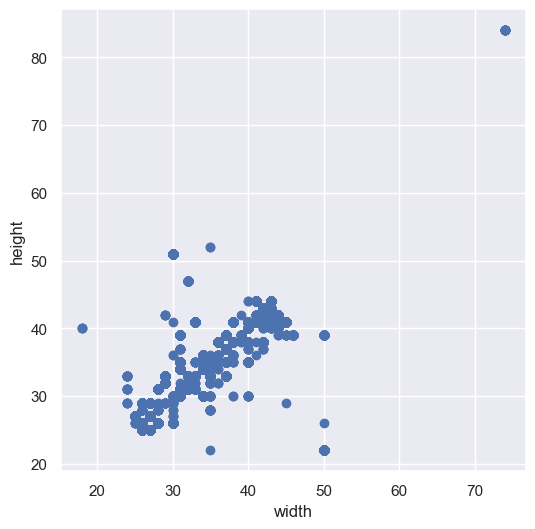

In [126]:
# image size distribution

x = [ img.shape[1] for img in train_img ]
y = [ img.shape[0] for img in train_img ]

# image size plot
plt.figure(figsize=(6,6))
plt.scatter(x,y)
plt.xlabel("width")
plt.ylabel("height")

In [129]:
from scipy import stats
# 추세선 계산 (선형 회귀 사용)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# 추세선 함수 정의 (x를 numpy 배열로 변환)
def trend_line(x):
    return slope * np.array(x) + intercept

# 데이터 포인트들과 추세선 사이의 거리 계산
distances = np.abs(y - trend_line(x))

# 거리가 가장 작은 데이터 포인트의 인덱스 찾기
optimal_index = np.argmin(distances)

# 최적 resize 크기
optimal_x = x[optimal_index]
optimal_y = y[optimal_index]

print(f"최적 resize 크기: ({optimal_x}, {optimal_y})")

최적 resize 크기: (42, 41)


In [130]:
print(slope)

0.8431617823898346


In [122]:
train_img.shape

(121123,)

In [133]:
train_img_resized = np.array([cv2.resize(img, dsize=(26, 26)) for img in train_img])

In [134]:
train_img_resized.shape

(121123, 26, 26)

In [135]:
faulty_case = np.unique(y_train)
print('Faulty case list : {}'.format(faulty_case))
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
Center : 3146
Donut : 354
Edge-Loc : 3389
Edge-Ring : 3180
Loc : 2306
Near-full : 114
Random : 567
Scratch : 600
none : 107467


In [137]:
x=train_img_resized.reshape((-1, 26, 26, 1))

In [138]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

C:\Users\USER\AppData\Local\Temp\ipykernel_6084\1672712627.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_x[w, i, j, int(x[w, i, j])] = 1


In [139]:
# none 레이블을 가진 데이터의 인덱스 찾기
none_idx = np.where(y_train == 'none')[0]

# none 레이블 데이터 삭제
x_train = np.delete(new_x, none_idx, axis=0)
y_train = np.delete(y_train, none_idx, axis=0)


In [141]:
faulty_case = np.unique(y_train)
print('Faulty case list : {}'.format(faulty_case))
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch']
Center : 3146
Donut : 354
Edge-Loc : 3389
Edge-Ring : 3180
Loc : 2306
Near-full : 114
Random : 567
Scratch : 600


In [142]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    y_train[y_train==l] = i
    
# one-hot-encoding
y_train = to_categorical(y_train)

In [202]:
test_df=pd.read_pickle("df_test.pkl")
test_df = test_df.drop(['waferIndex'], axis = 1)
test_labeled_data = test_df[test_df['failureType'].astype(str) != '[]'].copy()
test_img=test_labeled_data['waferMap'].values



In [203]:
y_test = np.array(test_labeled_data['failureType']).reshape(-1,1)


In [204]:
print(test_img.dtype)

object


In [205]:
print(test_img.shape)
print(y_test.shape)

(34590,)
(34590, 1)


In [206]:
test_img_resized = np.array([cv2.resize(img, dsize=(26, 26)) for img in test_img])
x_test=test_img_resized.reshape((-1, 26, 26, 1))


In [207]:
x_test.shape

(34590, 26, 26, 1)

In [208]:
# none 레이블을 가진 데이터의 인덱스 찾기
none_idx = np.where(y_test == 'none')[0]

# none 레이블 데이터 삭제
x_test = np.delete(x_test, none_idx, axis=0)
y_test = np.delete(y_test, none_idx, axis=0)

In [209]:
# One-hot-Encoding faulty categorical variable as channel
new_x_test = np.zeros((len(x_test), 26, 26, 3))

for w in range(len(x_test)):
    for i in range(26):
        for j in range(26):
            new_x_test[w, i, j, int(x_test[w, i, j])] = 1

C:\Users\USER\AppData\Local\Temp\ipykernel_6084\3065255790.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_x_test[w, i, j, int(x_test[w, i, j])] = 1


In [210]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i
    
# one-hot-encoding
y_test = to_categorical(y_test)

In [211]:
print(new_x_test.shape)
print(y_test.shape)

(5104, 26, 26, 3)
(5104, 8)


In [153]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(8, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [154]:
x_train.shape

(13656, 26, 26, 3)

In [155]:
y_train.shape

(13656, 8)

In [158]:
with tf.device('/cpu:0'):
# Make keras model to sklearn classifier.
    model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
    kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
    results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
    print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

C:\Users\USER\AppData\Local\Temp\ipykernel_6084\359353576.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2)


Epoch 1/10
9/9 - 54s - loss: 3.1754 - accuracy: 0.3099 - 54s/epoch - 6s/step
Epoch 2/10
9/9 - 53s - loss: 1.2376 - accuracy: 0.5939 - 53s/epoch - 6s/step
Epoch 3/10
9/9 - 52s - loss: 0.7388 - accuracy: 0.7309 - 52s/epoch - 6s/step
Epoch 4/10
9/9 - 53s - loss: 0.5511 - accuracy: 0.7967 - 53s/epoch - 6s/step
Epoch 5/10
9/9 - 53s - loss: 0.4801 - accuracy: 0.8174 - 53s/epoch - 6s/step
Epoch 6/10
9/9 - 55s - loss: 0.4324 - accuracy: 0.8339 - 55s/epoch - 6s/step
Epoch 7/10
9/9 - 55s - loss: 0.3973 - accuracy: 0.8467 - 55s/epoch - 6s/step
Epoch 8/10
9/9 - 56s - loss: 0.3720 - accuracy: 0.8563 - 56s/epoch - 6s/step
Epoch 9/10
9/9 - 54s - loss: 0.3402 - accuracy: 0.8728 - 54s/epoch - 6s/step
Epoch 10/10
9/9 - 54s - loss: 0.3102 - accuracy: 0.8832 - 54s/epoch - 6s/step
5/5 - 8s - loss: 0.3887 - accuracy: 0.8526 - 8s/epoch - 2s/step
Epoch 1/10
9/9 - 57s - loss: 2.6315 - accuracy: 0.2758 - 57s/epoch - 6s/step
Epoch 2/10
9/9 - 55s - loss: 1.2365 - accuracy: 0.5560 - 55s/epoch - 6s/step
Epoch 3/10


In [160]:
with tf.device('/cpu:0'):
    # Keras 모델 생성
    model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=1024, verbose=2) 

    # 모델 학습 (교차 검증 없이 전체 훈련 데이터 사용)
    model.fit(x_train, y_train)

C:\Users\USER\AppData\Local\Temp\ipykernel_6084\64607208.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=1024, verbose=2)


Epoch 1/15
14/14 - 82s - loss: 2.9330 - accuracy: 0.3207 - 82s/epoch - 6s/step
Epoch 2/15
14/14 - 74s - loss: 0.9210 - accuracy: 0.6690 - 74s/epoch - 5s/step
Epoch 3/15
14/14 - 73s - loss: 0.5958 - accuracy: 0.7748 - 73s/epoch - 5s/step
Epoch 4/15
14/14 - 73s - loss: 0.4934 - accuracy: 0.8177 - 73s/epoch - 5s/step
Epoch 5/15
14/14 - 74s - loss: 0.4292 - accuracy: 0.8396 - 74s/epoch - 5s/step
Epoch 6/15
14/14 - 75s - loss: 0.3814 - accuracy: 0.8557 - 75s/epoch - 5s/step
Epoch 7/15
14/14 - 73s - loss: 0.3418 - accuracy: 0.8705 - 73s/epoch - 5s/step
Epoch 8/15
14/14 - 73s - loss: 0.3112 - accuracy: 0.8837 - 73s/epoch - 5s/step
Epoch 9/15
14/14 - 74s - loss: 0.3056 - accuracy: 0.8823 - 74s/epoch - 5s/step
Epoch 10/15
14/14 - 73s - loss: 0.2670 - accuracy: 0.9016 - 73s/epoch - 5s/step
Epoch 11/15
14/14 - 73s - loss: 0.2442 - accuracy: 0.9105 - 73s/epoch - 5s/step
Epoch 12/15
14/14 - 73s - loss: 0.2266 - accuracy: 0.9163 - 73s/epoch - 5s/step
Epoch 13/15
14/14 - 73s - loss: 0.2031 - accuracy

In [169]:
new_x_test.shape

(5104, 26, 26, 3)

In [170]:
y_pred.shape

(5104,)

In [212]:
 
from sklearn.metrics import accuracy_score

with tf.device('/cpu:0'):

   # 훈련된 모델로 예측 수행 (옵션)
   y_pred = model.predict(new_x_test)
   y_pred_one_hot = to_categorical(y_pred, num_classes=8)  # num_classes는 클래스 개수에 맞게 설정

   # 모델 평가
   score = accuracy_score(y_test, y_pred_one_hot)  
   # 또는 다른 적절한 평가 지표 사용
   print('Simple CNN Accuracy: {:.4f}'.format(score))

160/160 [==============================] - 16s 100ms/step
Simple CNN Accuracy: 0.8123
